# How to add chat history

:::note

This guide previously used the [RunnableWithMessageHistory](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html) abstraction. You can access this version of the documentation in the [v0.2 docs](https://python.langchain.com/v0.2/docs/how_to/qa_chat_history_how_to/).

As of the v0.3 release of LangChain, we recommend that LangChain users take advantage of [LangGraph persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) to incorporate `memory` into new LangChain applications.

If your code is already relying on `RunnableWithMessageHistory` or `BaseChatMessageHistory`, you do **not** need to make any changes. We do not plan on deprecating this functionality in the near future as it works for simple chat applications and any code that uses `RunnableWithMessageHistory` will continue to work as expected.

Please see [How to migrate to LangGraph Memory](/docs/versions/migrating_memory/) for more details.
:::


In many [Q&A applications](/docs/concepts/rag/) we want to allow the user to have a back-and-forth conversation, meaning the application needs some sort of "memory" of past questions and answers, and some logic for incorporating those into its current thinking.

In this guide we focus on **adding logic for incorporating historical messages.**

This is largely a condensed version of the [Conversational RAG tutorial](/docs/tutorials/qa_chat_history).

We will cover two approaches:
1. [Chains](/docs/how_to/qa_chat_history_how_to#chains), in which we always execute a retrieval step;
2. [Agents](/docs/how_to/qa_chat_history_how_to#agents), in which we give an LLM discretion over whether and how to execute a retrieval step (or multiple steps).

For the external knowledge source, we will use the same [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng from the [RAG tutorial](/docs/tutorials/rag).

Both approaches leverage [LangGraph](https://langchain-ai.github.io/langgraph/) as an orchestration framework. LangGraph implements a built-in [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/), making it ideal for chat applications that support multiple conversational turns.

## Setup

### Dependencies

We'll use OpenAI embeddings and an InMemory vector store in this walkthrough, but everything shown here works with any [Embeddings](/docs/concepts/embedding_models), and [VectorStore](/docs/concepts/vectorstores) or [Retriever](/docs/concepts/retrievers). 

We'll use the following packages:

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with [LangSmith](https://smith.langchain.com).

Note that LangSmith is not needed, but it is helpful. If you do want to use LangSmith, after you sign up at the link above, make sure to set your environment variables to start logging traces:

```python
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

### Components

We will need to select three components from LangChain's suite of integrations.

A [chat model](/docs/integrations/chat/):

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [2]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

An [embedding model](/docs/integrations/text_embedding/):

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [3]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

And a [vector store](/docs/integrations/vectorstores/):

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [4]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Chains {#chains}

The [RAG Tutorial](/docs/tutorials/rag) indexes an [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng. We will repeat that here. Below we load the content of the page, split it into sub-documents, and embed the documents into our [vector store](/docs/concepts/vectorstores/):

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

As detailed in [Part 2](/docs/tutorials/qa_chat_history) of the RAG tutorial, we can naturally support a conversational experience by representing the flow of the RAG application as a sequence of [messages](/docs/concepts/messages/):

1. User input as a `HumanMessage`;
2. Vector store query as an `AIMessage` with tool calls;
3. Retrieved documents as a `ToolMessage`;
4. Final response as a `AIMessage`.

We will use [tool-calling](/docs/concepts/tool_calling/) to facilitate this, which additionally allows the query to be generated by the LLM. We can build a [tool](/docs/concepts/tools) to execute the retrieval step:

In [8]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

We can now build our LangGraph application.

Note that we compile it with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/) to support a back-and-forth conversation. LangGraph comes with a simple [in-memory checkpointer](https://langchain-ai.github.io/langgraph/reference/checkpoints/#memorysaver), which we use below. See its documentation for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

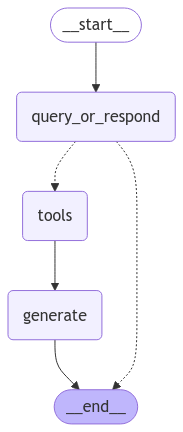

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application.

Note that it responds appropriately to messages that do not require an additional retrieval step:

In [11]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [12]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


And when executing a search, we can stream the steps to observe the query generation, retrieval, and answer generation:

In [14]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_RntwX5GMt531biEE9MqSbgLV)
 Call ID: call_RntwX5GMt531biEE9MqSbgLV
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

Finally, because we have compiled our application with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/), historical messages are maintained in the state. This allows the model to contextualize user queries:

In [15]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_kwO5rYPyJ0MftYKoKRFjKpZM)
 Call ID: call_kwO5rYPyJ0MftYKoKRFjKpZM
  Args:
    query: common methods for task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting li

Note that we can observe the full sequence of messages sent to the chat model-- including tool calls and retrieved context-- in the [LangSmith trace](https://smith.langchain.com/public/3c85919e-9609-4a0d-8df1-21726f8f3e5c/r).

The conversation history can also be inspected via the state of the application:

In [18]:
chat_history = graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_RntwX5GMt531biEE9MqSbgLV)
 Call ID: call_RntwX5GMt531biEE9MqSbgLV
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for

## Agents {#agents}

[Agents](/docs/concepts/agents) leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allows you to offload additional discretion over the retrieval process. Although their behavior is less predictable than the above "chain", they are able to execute multiple retrieval steps in service of a query, or iterate on a single search.

Below we assemble a minimal RAG agent. Using LangGraph's [pre-built ReAct agent constructor](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent), we can do this in one line.

:::tip

Check out LangGraph's [Agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) tutorial for more advanced formulations.

:::

In [19]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

Let's inspect the graph:

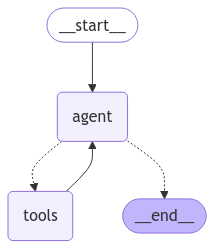

In [20]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

The key difference from our earlier implementation is that instead of a final generation step that ends the run, here the tool invocation loops back to the original LLM call. The model can then either answer the question using the retrieved context, or generate another tool call to obtain more information.

Let's test this out. We construct a question that would typically require an iterative sequence of retrieval steps to answer:

In [21]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_rxBqio7dxthnMuzjr4AIquSZ)
 Call ID: call_rxBqio7dxthnMuzjr4AIquSZ
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majori

Note that the agent:

1. Generates a query to search for a standard method for task decomposition;
2. Receiving the answer, generates a second query to search for common extensions of it;
3. Having received all necessary context, answers the question.

We can see the full sequence of steps, along with latency and other metadata, in the [LangSmith trace](https://smith.langchain.com/public/48cbd35e-9ac1-49ab-8c09-500d54c06b81/r).

## Next steps

We've covered the steps to build a basic conversational Q&A application:

- We used chains to build a predictable application that generates search queries for each user input;
- We used agents to build an application that "decides" when and how to generate search queries.

To explore different types of retrievers and retrieval strategies, visit the [retrievers](/docs/how_to#retrievers) section of the how-to guides.

For a detailed walkthrough of LangChain's conversation memory abstractions, visit the [How to add message history (memory)](/docs/how_to/message_history) LCEL page.

To learn more about agents, head to the [Agents Modules](/docs/tutorials/agents).